# Procedures
1. Gaussian Filter
1. Threshholding
1. Enhance Contrast
    1. Histogram Equalization
    2. Adaptive Histogram Equalization(adaptive)
    3. Contrast Limited Adaptive Histogram Equalization(limited adaptive) (CLAHE)
1. Noise Reduction
1. HOG
1. LBP
1. Algorithms
    1. SVM
    2. CNN
    3. VGG-16
    4. RESNET
1. Evealuation
    1. Classification Accuracy
    2. Logarithmic Loss
    3. Confussion Matrix
    4. Area Under Curve
    5. F1 Score
    6. Mean Absolute Error
    7. Mean Square Error

### Necessary Imports

In [248]:
import json
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage import exposure
from skimage.filters import gaussian
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
from skimage.feature import hog, local_binary_pattern
import timeit

### Necessary Configs

In [249]:
with open('config.json') as file:
    config = json.load(file)
np.random.seed(42)


### Necessary Paths
📦feature-extraction-classification <br>
 ┣ 📂datasets <br>
 ┃ ┣ 📂label1 <br>
 ┃ ┃ ┗ 📜image <br>
 ┃ ┣ 📂label2 <br>
 ┃ ┃ ┗ 📜image <br>
 ┃ ┗ 📂label3 <br>
 ┃  &nbsp; ┗ 📜image <br>
 ┣ 📜config.json <br>
 ┗ 📜main.ipynb

In [250]:
ds_path = join(Path('__file__').parent.absolute(), 'datasets')

### Decorators
- `get_time`
<p>
    It's a decorator that gives the execution time of any function.
</p>

In [251]:
def get_time(func):
    def start_timer():
        start_time = timeit.default_timer()
        _ = func()
        print(f'{func.__name__}() takes {timeit.default_timer() - start_time}sec')
        return _
    return start_timer
def train_test_info(func):
    def print_info(data, test_size = 0.25):
        train, test = func(data, test_size = 0.25)
        print(f'test size percentage = {test_size * 100}%', f'train size = {len(train)}', f'test size = {len(test)}', sep='\n')
        return train, test
    return print_info


### Necessary Functions
- `show_img`
<p>
    parameters: 
    <ul>
        <li><i>img: fname | BinaryIO</i></li>
        <li><i>title: 'Image' | str</i></li>
        <li><i>
            cmap_type: None | str <br>
            It defines color map, None represents rgb by default. It takes values like Greys etc.
        </i></li>
    </ul>
</p>
- `show_hist`
<p>
    parameters: 
    <ul>
        <li><i>img: fname | BinaryIO</i></li>
        <li><i>color: 'all' | str</i></li>
        <li><i>bins: 256 | number</i></li>
        <li><i>suptitle: 'histogram of various color channels' | str</i></li>
    </ul>
</p>
- `compare_img`
<p>
    parameters: 
    <ul>
        <li><i>
            *args: fname | BinaryIO<br>
            It takes iterable of fname or BinaryIO object.
        </i></li>
        <li><i>
            imgs_title: str<br>
            It takes iterable of str.
        </i></li>
        <li><i>suptitle: 'comparing original and other image' | str</i></li>
        <li><i>
            cmap: None | str <br>
            It defines color map, None represents rgb by default. It takes values like Greys etc.
        </i></li>
        <li><i>
            max_col: 5 | number <br>
            It defines maximumu column of subplot in a single row.
        </i></li>
    </ul>
</p>
- `load_img`
<p>
    returns: 
    <i>
        It yields the ndarray of image object.
    </i>
</p>
- `read_dataset`
<p>
    parameters: 
    <ul>
        <li><i>
            callback: 'function'
        </i></li>
    </ul>
</p>
<p>
    returns: 
    <ul>
        <li><i>It yields the ndarray of image object.</i></li>
        <li><i>
    Or by default this function yields image object but by callback property it can do customize task inside datasets folder.
    </i></li>
    </ul>
</p>
- `collect_labels`
<p>
    returns: 
    <i>
        It yields the name of various labels or names of folder inside datasets folder.
    </i>
</p>
- `merge_feat_lab`
<p>
    parameters: 
    <ul>
        <li><i>
            feat_extract_algo: None | lbp_f
        </i></li>
    </ul>
</p>
<p>
    returns: 
    <ul>
        <li><i>ndarray of (feature: HOG descripter for the image | LBP Image, labels: str, img_view: A visualization of HOG image | None, img: fname | BinaryIO)</i></li>
    </ul>
</p>

> *`None` means it takes `hog_f` as default parameter, or it can take `lbp_f` as parameter.*


In [252]:
rgb2gray = lambda original: color.rgb2gray(original)
rgb = lambda original: color.gray2rgb(original)
read = lambda path: plt.imread(path)
img_red = lambda img: img[:, :, 0]
img_green = lambda img: img[:, :, 1]
img_blue = lambda img: img[:, :, 2]
size = lambda img: img.size
shape = lambda img: img.shape
img_flp_v = lambda img: np.flipud(img)
img_flip_h = lambda img: np.fliplr(img)
gaussian_filtr = lambda img: gaussian(img, multichannel=True)
img_hist_eq = lambda img: exposure.equalize_hist(img)
img_clahe = lambda img: exposure.equalize_adapthist(img, clip_limit=0.03)
img_denoise_tv = lambda img: denoise_tv_chambolle(img, multichannel=True)
img_denoise_bilateral = lambda img: denoise_bilateral(img, multichannel=True)
def show_img(img, title='Image', cmap_type = None):
    plt.imshow(img, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()
def show_hist(img, color='all', bins=256, suptitle='histogram of various color channels'):
    func_map = [img_red, img_green, img_blue]
    col_map = ['red', 'green', 'blue']
    def make_plt(func, title, color):
        plt.hist(func(img).flatten(), bins=bins, color=color)
        plt.title(title)
    if color == 'all':
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            make_plt(func_map[i], col_map[i] + ' channel', col_map[i])
    if color == 'r':
        make_plt(func_map[0], col_map[i] + ' channel', col_map[i])
    if color == 'g':
        make_plt(func_map[1], col_map[i] + ' channel', col_map[i])
    if color == 'b':
        make_plt(func_map[2], col_map[i] + ' channel', col_map[i])
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()
def compare_img(*args, imgs_title, suptitle='comparing original and other image', cmap=None, max_col = 5):
    max_col = max_col if len(args) >= max_col else len(args)
    row_counter = len(args) // max_col if len(args) % max_col == 0 else len(args) // max_col + 1 
    for i in range(len(args)):
        plt.subplot(row_counter, max_col, i + 1)
        plt.imshow(args[i], cmap=cmap)
        plt.title(imgs_title[i])
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(suptitle)
    plt.show()
def load_img():
    yield from read_dataset()
def read_dataset(callback = None):
    for file in listdir(ds_path):
        img_path = join(ds_path, file)
        if isfile(img_path):
            if callback: yield callback(file)
            else: yield read(img_path)
        else: 
            for _file in listdir(join(ds_path, file)):
                if callback: yield callback(file)
                else:
                    img_path = join(ds_path, file, _file)
                    if isfile(img_path): yield read(img_path)            
def collect_labels():
    yield from read_dataset(lambda file: file)
def merge_feat_lab(feat_extract_algo = None):
    feat_extract_algo = lbp_f if feat_extract_algo else hog_f
    def get_img():
        labels = list(collect_labels())
        for index, img in enumerate(load_img()):
            if feat_extract_algo == lbp_f: feature, img_view = lbp_f(img), None
            else: feature, img_view = hog_f(img) 
            yield (feature, labels[index], img_view, img)
    merged_feat_lab = np.array(list(get_img()), dtype=object)
    np.random.shuffle(merged_feat_lab)
    return merged_feat_lab
@train_test_info
def train_test(data, test_size = 0.25):
    test_size = int(test_size * len(data))
    return data[test_size:], data[: test_size]


### Feature Extraction Algorithms
- `hog_f`
<p>
    parameters: 
    <ul>
        <li><i>img: fname | BinaryIO</i></li>
    </ul>
</p>
<p>
    returns: 
    <ul>
        <li><i>HOG descripter for the image: ndarray</i></li>
        <li><i>A visualization of HOG image: ndarray</i></li>
    </ul>
</p>

> *for returning both of the values, make sure `feature_vector` and `visualize` set to `True`*

- `lbp_f`
<p>
    parameters: 
    <ul>
        <li><i>img: fname | BinaryIO</i></li>
    </ul>
</p>
<p>
    returns: 
    <ul>
        <li><i>LBP Image: ndarray</i></li>
    </ul>
</p>

In [253]:
hog_f = lambda img: hog(img, orientations=config['hog']['orientations'], pixels_per_cell=tuple(config['hog']['pixels_per_cell']), cells_per_block=tuple(config['hog']['cells_per_block']), block_norm=config['hog']['block_norm'], visualize=config['hog']['visualize'], transform_sqrt=config['hog']['transform_sqrt'], feature_vector=config['hog']['feature_vector'], multichannel=config['hog']['multichannel'])

lbp_f = lambda img: local_binary_pattern(rgb2gray(img), P=config['lbp']['P'], R=config['lbp']['R'], method=config['lbp']['method'])

### Classification Algorithms

### Evealuation Techniques

### Working Pipeline

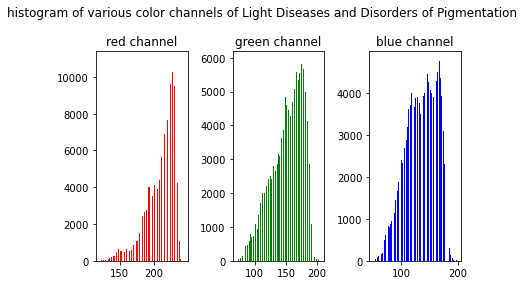

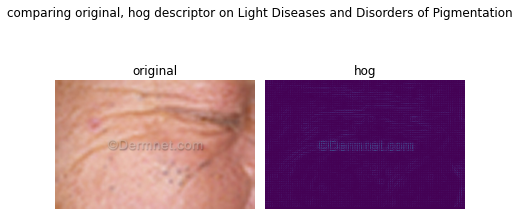

hog_feat() takes 7.551451541999995sec


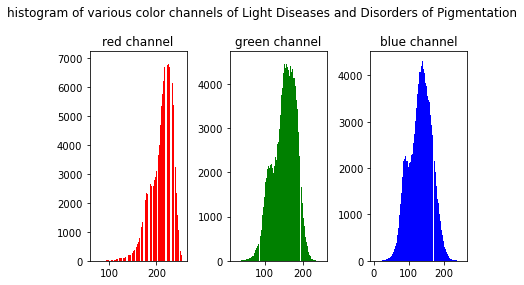

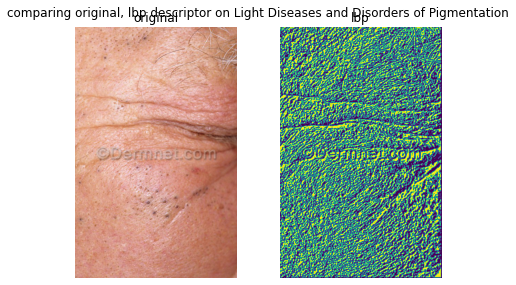

lbp_feat() takes 4.0467480219995196sec


In [254]:
@get_time
def hog_feat():
    for merged_data in merge_feat_lab():
        show_hist(merged_data[-1], suptitle='histogram of various color channels of ' + merged_data[1])
        descriptor_img = merged_data[0] if merged_data[2] is None else merged_data[2]
        compare_img(merged_data[-1], descriptor_img, imgs_title=['original', 'hog'], suptitle='comparing original, hog descriptor on ' + merged_data[1])
        break

@get_time
def lbp_feat():
    for merged_data in merge_feat_lab(lbp_f):
        show_hist(merged_data[-1], suptitle='histogram of various color channels of ' + merged_data[1])
        descriptor_img = merged_data[0] if merged_data[2] is None else merged_data[2]
        compare_img(merged_data[-1], descriptor_img, imgs_title=['original', 'lbp'], suptitle='comparing original, lbp descriptor on ' + merged_data[1])
        break

hog_feat()
lbp_feat()